<a href="https://colab.research.google.com/github/souravsudheer/Predicting-ICU-Readmission-Rates-Using-Machine-Learning-An-Analysis-of-ANZICS-2024-Data/blob/main/ANZICS_db_AnalysisClaude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================
# 1.1 IMPORTS AND CONFIGURATION
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

✓ Libraries imported successfully
Pandas version: 2.2.2
Numpy version: 2.0.2


In [2]:
# ==========================================
# 1.2 DATA LOADING
# ==========================================

def load_anzics_data(apd_path, ccr_path):
    """Load ANZICS datasets with error handling"""

    try:
        print("\n" + "="*50)
        print("Loading ANZICS Adult Patient Database...")
        apd = pd.read_csv(apd_path, low_memory=False)
        print(f"✓ APD loaded: {apd.shape[0]:,} admissions, {apd.shape[1]} variables")
    except FileNotFoundError:
        print(f"❌ APD file not found at: {apd_path}")
        print("Please update the path to your APD CSV file")
        return None, None
    except Exception as e:
        print(f"❌ Error loading APD: {str(e)}")
        return None, None

    try:
        print("\nLoading Critical Care Resources Registry...")
        ccr = pd.read_csv(ccr_path, low_memory=False)
        print(f"✓ CCR loaded: {ccr.shape[0]:,} records, {ccr.shape[1]} variables")
    except FileNotFoundError:
        print(f"⚠️ CCR file not found at: {ccr_path}")
        print("Continuing with APD data only...")
        ccr = pd.DataFrame()  # Empty dataframe
    except Exception as e:
        print(f"⚠️ Error loading CCR: {str(e)}")
        ccr = pd.DataFrame()

    return apd, ccr

# ==========================================
# 1.3 EXECUTE LOADING
# ==========================================

apd_path = '/content/drive/MyDrive/Colab Notebooks/ANZICS_APD_FY2018_FY2023.csv'
ccr_path = '/content/drive/MyDrive/Colab Notebooks/ANZICS_CCR_FY2018_FY2023.csv'

# Load the data
apd, ccr = load_anzics_data(apd_path, ccr_path)

# ==========================================
# 1.4 BASIC VALIDATION
# ==========================================

if apd is not None:
    print("\n" + "="*50)
    print("DATA LOADING SUMMARY")
    print("="*50)

    # Check for critical columns
    critical_cols = ['died_icu', 'died_hosp', 'age', 'apache3score', 'icu_hrs']
    missing_cols = [col for col in critical_cols if col not in apd.columns]

    if missing_cols:
        print(f"⚠️ Missing critical columns: {missing_cols}")
    else:
        print("✓ All critical columns present")

    # Quick data preview
    print(f"\nFirst few rows of APD data:")
    print(apd.head(3))

    # Memory usage
    memory_mb = apd.memory_usage(deep=True).sum() / 1024**2
    print(f"\nMemory usage: {memory_mb:.2f} MB")

    print("\n✓ Chunk 1 Complete! Data loaded successfully.")
    print("Ready to proceed to Chunk 2: Data Overview")
else:
    print("\n❌ Data loading failed. Please check your file paths and try again.")


Loading ANZICS Adult Patient Database...
✓ APD loaded: 1,143,285 admissions, 177 variables

Loading Critical Care Resources Registry...
✓ CCR loaded: 1,095 records, 84 variables

DATA LOADING SUMMARY
✓ All critical columns present

First few rows of APD data:
  HospitalClassification PublicPrivate PatientID IcuAdmFinYr  IcuAdmYYYYMM  \
0       Rural / Regional        Public      5423     2017-18        201709   
1       Rural / Regional        Public      5976     2017-18        201709   
2       Rural / Regional        Public      6070     2017-18        201711   

   IcuAdmYear  IcuAdmMonth  IcuAdmDay  IcuAdmHour  IcuDisYear  IcuDisMonth  \
0        2017            9         16           4     2017.00         9.00   
1        2017            9         29           1     2017.00        10.00   
2        2017           11         10          15     2017.00        11.00   

   IcuDisDay  IcuDisHour  hosp_srce  hosp_outcm  hosp_hrs sex  icu_srce  \
0      18.00       22.00       1.00   

In [4]:
print("="*80)
print("COMPREHENSIVE EDA - PART 1: DEMOGRAPHICS & ADMISSION CHARACTERISTICS")
print("="*80)

# ==========================================
# 1. DEMOGRAPHIC ANALYSIS
# ==========================================

print("\n" + "="*60)
print("1. DEMOGRAPHIC ANALYSIS")
print("="*60)

# 1.1 Age Distribution Analysis
print("\n📊 1.1 AGE DISTRIBUTION ANALYSIS")
print("-"*40)

# Basic statistics
print(f"Age Statistics:")
print(f"  Mean: {apd['age'].mean():.1f} years")
print(f"  Median: {apd['age'].median():.1f} years")
print(f"  Std Dev: {apd['age'].std():.1f} years")
print(f"  Min: {apd['age'].min():.0f} years")
print(f"  Max: {apd['age'].max():.0f} years")
print(f"  Skewness: {apd['age'].skew():.2f}")
print(f"  Kurtosis: {apd['age'].kurtosis():.2f}")

# Age distribution by percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
age_percentiles = apd['age'].quantile([p/100 for p in percentiles])
print(f"\nAge Percentiles:")
for p, val in zip(percentiles, age_percentiles):
    print(f"  {p}th percentile: {val:.0f} years")

# Age group analysis with clinical context
apd['age_group'] = pd.cut(apd['age'],
                          bins=[0, 18, 45, 65, 75, 85, 120],
                          labels=['16-18 (Pediatric transition)',
                                  '19-45 (Young adult)',
                                  '46-65 (Middle age)',
                                  '66-75 (Young elderly)',
                                  '76-85 (Elderly)',
                                  '86+ (Very elderly)'])

print(f"\nAge Group Distribution:")
age_dist = apd['age_group'].value_counts().sort_index()
for group, count in age_dist.items():
    pct = count/len(apd)*100
    mort = (apd[apd['age_group']==group]['died_hosp'] == 1).mean() * 100
    print(f"  {group}: {count:,} ({pct:.1f}%) - Mortality: {mort:.1f}%")

# 1.2 Sex Distribution Analysis
print("\n📊 1.2 SEX DISTRIBUTION ANALYSIS")
print("-"*40)

sex_dist = apd['sex'].value_counts()
print(f"Sex Distribution:")
for sex, count in sex_dist.items():
    pct = count/len(apd)*100
    mort = (apd[apd['sex']==sex]['died_hosp'] == 1).mean() * 100
    mean_age = apd[apd['sex']==sex]['age'].mean()
    print(f"  {sex}: {count:,} ({pct:.1f}%) - Mortality: {mort:.1f}%, Mean age: {mean_age:.1f}")

# Sex ratio by age group
print(f"\nMale:Female Ratio by Age Group:")
for age_group in age_dist.index:
    age_sex = apd[apd['age_group']==age_group]['sex'].value_counts()
    if 'M' in age_sex.index and 'F' in age_sex.index:
        ratio = age_sex['M'] / age_sex['F']
        print(f"  {age_group}: {ratio:.2f}:1")

# 1.3 Indigenous Status Analysis
print("\n📊 1.3 INDIGENOUS STATUS ANALYSIS")
print("-"*40)

# Fix the encoding issue (1=yes, 2=no)
apd['indigenous_fixed'] = apd['indigenous'].map({1: 'Indigenous', 2: 'Non-Indigenous'})

indigenous_dist = apd['indigenous_fixed'].value_counts(dropna=False)
print(f"Indigenous Status Distribution:")
for status, count in indigenous_dist.items():
    pct = count/len(apd)*100
    if pd.notna(status):
        mort = (apd[apd['indigenous_fixed']==status]['died_hosp'] == 1).mean() * 100
        age = apd[apd['indigenous_fixed']==status]['age'].mean()
        print(f"  {status}: {count:,} ({pct:.1f}%) - Mortality: {mort:.1f}%, Mean age: {age:.1f}")
    else:
        print(f"  Missing: {count:,} ({pct:.1f}%)")

# ==========================================
# 2. ADMISSION CHARACTERISTICS
# ==========================================

print("\n" + "="*60)
print("2. ADMISSION CHARACTERISTICS")
print("="*60)

# 2.1 Admission Type Analysis
print("\n📊 2.1 ELECTIVE VS EMERGENCY ADMISSIONS")
print("-"*40)

# Fix elective encoding (1=elective, 2=not elective)
apd['elective_fixed'] = apd['elect'].map({1: 'Elective', 2: 'Emergency'})

elective_dist = apd['elective_fixed'].value_counts(dropna=False)
print(f"Admission Type Distribution:")
for admit_type, count in elective_dist.items():
    pct = count/len(apd)*100
    if pd.notna(admit_type):
        mort = (apd[apd['elective_fixed']==admit_type]['died_hosp'] == 1).mean() * 100
        los = apd[apd['elective_fixed']==admit_type]['icu_hrs'].median()
        vent = (apd[apd['elective_fixed']==admit_type]['ventilated'] == 1).mean() * 100
        print(f"  {admit_type}: {count:,} ({pct:.1f}%)")
        print(f"    - Mortality: {mort:.1f}%")
        print(f"    - Median LOS: {los:.1f} hours")
        print(f"    - Ventilation rate: {vent:.1f}%")
    else:
        print(f"  Missing: {count:,} ({pct:.1f}%)")

# 2.2 Admission Source Analysis
print("\n📊 2.2 ICU ADMISSION SOURCE")
print("-"*40)

# Map admission sources to meaningful names
source_map = {
    1: 'Operating Theatre/Recovery',
    2: 'Emergency Department',
    3: 'Hospital Ward',
    4: 'Other ICU (same hospital)',
    5: 'Other Hospital (ward)',
    6: 'Other Hospital (ICU)',
    9: 'Direct from Home'
}

apd['source_name'] = apd['icu_srce'].map(source_map)

source_dist = apd['source_name'].value_counts()
print(f"ICU Admission Source:")
for source, count in source_dist.items():
    pct = count/len(apd)*100
    mort = (apd[apd['source_name']==source]['died_hosp'] == 1).mean() * 100
    los = apd[apd['source_name']==source]['icu_hrs'].median()
    print(f"  {source}: {count:,} ({pct:.1f}%)")
    print(f"    - Mortality: {mort:.1f}%, Median LOS: {los:.1f}h")

# 2.3 Pre-ICU Time Analysis
print("\n📊 2.3 PRE-ICU TIME ANALYSIS")
print("-"*40)

# Remove extreme outliers for analysis (>30 days pre-ICU)
pre_icu_clean = apd[apd['pre_icu_hrs'] <= 720]['pre_icu_hrs'].dropna()

print(f"Pre-ICU Hours Statistics (outliers >30 days removed):")
print(f"  Mean: {pre_icu_clean.mean():.1f} hours")
print(f"  Median: {pre_icu_clean.median():.1f} hours")
print(f"  75th percentile: {pre_icu_clean.quantile(0.75):.1f} hours")
print(f"  90th percentile: {pre_icu_clean.quantile(0.90):.1f} hours")
print(f"  95th percentile: {pre_icu_clean.quantile(0.95):.1f} hours")

# Categorize pre-ICU time
apd['pre_icu_category'] = pd.cut(apd['pre_icu_hrs'],
                                  bins=[-1, 6, 24, 72, 720, 10000],
                                  labels=['Direct (<6h)', 'Early (6-24h)',
                                          'Delayed (1-3d)', 'Prolonged (3-30d)',
                                          'Extreme (>30d)'])

print(f"\nPre-ICU Time Categories:")
for cat in ['Direct (<6h)', 'Early (6-24h)', 'Delayed (1-3d)', 'Prolonged (3-30d)', 'Extreme (>30d)']:
    cat_data = apd[apd['pre_icu_category']==cat]
    if len(cat_data) > 0:
        count = len(cat_data)
        pct = count/len(apd)*100
        mort = (cat_data['died_hosp'] == 1).mean() * 100
        print(f"  {cat}: {count:,} ({pct:.1f}%) - Mortality: {mort:.1f}%")

# 2.4 Readmission Analysis
print("\n📊 2.4 READMISSION PATTERNS")
print("-"*40)

readmit_rate = (apd['readmitted'] == 1).mean() * 100
print(f"Overall readmission rate: {readmit_rate:.2f}%")

# Readmission by episode number
episode_dist = apd['admepisode'].value_counts().sort_index()
print(f"\nAdmission Episode Distribution:")
for episode in range(min(6, len(episode_dist))):
    if episode in episode_dist.index:
        count = episode_dist[episode]
        pct = count/len(apd)*100
        mort = (apd[apd['admepisode']==episode]['died_hosp'] == 1).mean() * 100
        print(f"  Episode {episode}: {count:,} ({pct:.1f}%) - Mortality: {mort:.1f}%")

# Time between readmissions
readmit_lag = apd[apd['readmission_lag_hrs'].notna()]['readmission_lag_hrs']
if len(readmit_lag) > 0:
    print(f"\nTime to Readmission (for readmitted patients):")
    print(f"  Median: {readmit_lag.median():.1f} hours")
    print(f"  Mean: {readmit_lag.mean():.1f} hours")
    print(f"  <24h: {(readmit_lag < 24).mean()*100:.1f}%")
    print(f"  <48h: {(readmit_lag < 48).mean()*100:.1f}%")
    print(f"  <72h: {(readmit_lag < 72).mean()*100:.1f}%")

# ==========================================
# 3. TEMPORAL PATTERNS
# ==========================================

print("\n" + "="*60)
print("3. TEMPORAL ADMISSION PATTERNS")
print("="*60)

# 3.1 Admission Hour Analysis
print("\n📊 3.1 ADMISSION HOUR PATTERNS")
print("-"*40)

# Hour of admission
hour_dist = apd['IcuAdmHour'].value_counts().sort_index()
business_hours = apd['IcuAdmHour'].between(8, 17).mean() * 100
after_hours = apd['IcuAdmHour'].isin([18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7]).mean() * 100

print(f"Admission timing:")
print(f"  Business hours (8am-5pm): {business_hours:.1f}%")
print(f"  After hours: {after_hours:.1f}%")

# Mortality by admission time
business_mort = (apd[apd['IcuAdmHour'].between(8, 17)]['died_hosp'] == 1).mean() * 100
afterhours_mort = (apd[~apd['IcuAdmHour'].between(8, 17)]['died_hosp'] == 1).mean() * 100
print(f"\nMortality by admission time:")
print(f"  Business hours: {business_mort:.2f}%")
print(f"  After hours: {afterhours_mort:.2f}%")
print(f"  Difference: {afterhours_mort - business_mort:+.2f} percentage points")

# 3.2 Day of Week Analysis
print("\n📊 3.2 DAY OF WEEK PATTERNS")
print("-"*40)

# Create datetime for day of week analysis - handle the specific column names
try:
    # Create a proper date string first
    apd['date_str'] = (apd['IcuAdmYear'].astype(int).astype(str) + '-' +
                       apd['IcuAdmMonth'].astype(int).astype(str).str.zfill(2) + '-' +
                       apd['IcuAdmDay'].astype(int).astype(str).str.zfill(2))
    apd['admission_date'] = pd.to_datetime(apd['date_str'], format='%Y-%m-%d', errors='coerce')
    apd['day_of_week'] = apd['admission_date'].dt.day_name()
except:
    print("Note: Day of week analysis skipped due to date formatting issues")
    apd['day_of_week'] = None

if apd['day_of_week'].notna().sum() > 0:
    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    print(f"Admissions by day of week:")
    for day in dow_order:
        day_data = apd[apd['day_of_week']==day]
        if len(day_data) > 0:
            count = len(day_data)
            pct = count/len(apd)*100
            mort = (day_data['died_hosp'] == 1).mean() * 100
            print(f"  {day}: {count:,} ({pct:.1f}%) - Mortality: {mort:.1f}%")

    # Weekend vs weekday
    apd['is_weekend'] = apd['day_of_week'].isin(['Saturday', 'Sunday'])
    weekend_mort = (apd[apd['is_weekend']]['died_hosp'] == 1).mean() * 100
    weekday_mort = (apd[~apd['is_weekend']]['died_hosp'] == 1).mean() * 100
    print(f"\nWeekend effect:")
    print(f"  Weekend mortality: {weekend_mort:.2f}%")
    print(f"  Weekday mortality: {weekday_mort:.2f}%")
    print(f"  Difference: {weekend_mort - weekday_mort:+.2f} percentage points")

print("\n" + "="*80)
print("Part 1 Complete - Continue with Part 2 for Clinical Variables Analysis")
print("="*80)

COMPREHENSIVE EDA - PART 1: DEMOGRAPHICS & ADMISSION CHARACTERISTICS

1. DEMOGRAPHIC ANALYSIS

📊 1.1 AGE DISTRIBUTION ANALYSIS
----------------------------------------
Age Statistics:
  Mean: 61.8 years
  Median: 65.0 years
  Std Dev: 17.6 years
  Min: 16 years
  Max: 97 years
  Skewness: -0.63
  Kurtosis: -0.28

Age Percentiles:
  1th percentile: 19 years
  5th percentile: 27 years
  10th percentile: 35 years
  25th percentile: 51 years
  50th percentile: 65 years
  75th percentile: 75 years
  90th percentile: 82 years
  95th percentile: 86 years
  99th percentile: 91 years

Age Group Distribution:
  16-18 (Pediatric transition): 11,390 (1.0%) - Mortality: 2.7%
  19-45 (Young adult): 201,104 (17.6%) - Mortality: 3.8%
  46-65 (Middle age): 367,221 (32.1%) - Mortality: 6.8%
  66-75 (Young elderly): 293,356 (25.7%) - Mortality: 8.7%
  76-85 (Elderly): 212,668 (18.6%) - Mortality: 11.6%
  86+ (Very elderly): 57,546 (5.0%) - Mortality: 14.1%

📊 1.2 SEX DISTRIBUTION ANALYSIS
---------------

In [2]:
# CHUNK 2 FIXED: CORRECTED DATA OVERVIEW
# This version properly handles the 1=yes, 2=no encoding

print("="*60)
print("DATA OVERVIEW")
print("="*60)

# ==========================================
# HELPER FUNCTION FOR BINARY VARIABLES
# ==========================================

def calc_binary_rate(column, yes_value=1):
    """Calculate rate for binary variables with 1=yes, 2=no encoding"""
    return (column == yes_value).mean() * 100

# ==========================================
# CORRECTED OUTCOME RATES
# ==========================================

print("\n📊 CORRECTED OUTCOME RATES:")
icu_mortality = calc_binary_rate(apd['died_icu'], 1)
hosp_mortality = calc_binary_rate(apd['died_hosp'], 1)
ventilation_rate = calc_binary_rate(apd['ventilated'], 1)
readmission_rate = calc_binary_rate(apd['readmitted'], 1)

print(f"ICU Mortality: {icu_mortality:.2f}%")
print(f"Hospital Mortality: {hosp_mortality:.2f}%")
print(f"Ventilation Rate: {ventilation_rate:.2f}%")
print(f"Readmission Rate: {readmission_rate:.2f}%")

# ==========================================
# MORTALITY BY KEY SUBGROUPS
# ==========================================

print("\n📊 MORTALITY BY SUBGROUPS:")

# By admission type (elective vs emergency)
print("\nBy Admission Type:")
emergency = apd[apd['elect'] == 0]
elective = apd[apd['elect'] == 1]
print(f"Emergency admissions - Mortality: {calc_binary_rate(emergency['died_hosp'], 1):.2f}%")
print(f"Elective admissions - Mortality: {calc_binary_rate(elective['died_hosp'], 1):.2f}%")

# By age groups
print("\nBy Age Group:")
apd['age_group'] = pd.cut(apd['age'],
                          bins=[0, 45, 65, 75, 85, 120],
                          labels=['<45', '45-64', '65-74', '75-84', '85+'])

for age_group in ['<45', '45-64', '65-74', '75-84', '85+']:
    group_data = apd[apd['age_group'] == age_group]
    mort_rate = calc_binary_rate(group_data['died_hosp'], 1)
    print(f"Age {age_group}: {mort_rate:.2f}% (n={len(group_data):,})")

# ==========================================
# SEVERITY SCORES - CORRECTED
# ==========================================

print("\n📈 SEVERITY SCORES:")

# APACHE III
apache3_available = apd['apache3score'].notna().sum()
apache3_pct = (apache3_available / len(apd)) * 100
print(f"APACHE III score available: {apache3_available:,} ({apache3_pct:.1f}%)")
print(f"  Mean APACHE III: {apd['apache3score'].mean():.1f}")
print(f"  Median APACHE III: {apd['apache3score'].median():.1f}")

# ANZROD (using correct column name)
anzrod_col = 'anzrod20riskofdeath'  # Using 2020 version
anzrod_available = apd[anzrod_col].notna().sum()
anzrod_pct = (anzrod_available / len(apd)) * 100
print(f"\nANZROD 2020 risk available: {anzrod_available:,} ({anzrod_pct:.1f}%)")
print(f"  Mean predicted mortality: {apd[anzrod_col].mean()*100:.2f}%")
print(f"  Median predicted mortality: {apd[anzrod_col].median()*100:.2f}%")

# ==========================================
# CALCULATE SMR (STANDARDIZED MORTALITY RATIO)
# ==========================================

print("\n📊 STANDARDIZED MORTALITY RATIOS:")

# ANZROD SMR
if 'anzrodissmr' in apd.columns:
    anzrod_eligible = apd[apd['anzrodissmr'] == 1].copy()
    observed_deaths = (anzrod_eligible['died_hosp'] == 1).sum()
    expected_deaths = anzrod_eligible[anzrod_col].sum()
    anzrod_smr = observed_deaths / expected_deaths if expected_deaths > 0 else None

    print(f"\nANZROD SMR Analysis:")
    print(f"  Eligible patients: {len(anzrod_eligible):,}")
    print(f"  Observed deaths: {observed_deaths:,}")
    print(f"  Expected deaths: {expected_deaths:.0f}")
    if anzrod_smr:
        print(f"  SMR: {anzrod_smr:.3f}")
        if anzrod_smr < 1:
            print(f"  → Performance {(1-anzrod_smr)*100:.1f}% BETTER than expected")
        else:
            print(f"  → Performance {(anzrod_smr-1)*100:.1f}% WORSE than expected")

# APACHE III SMR
if 'apache3issmr' in apd.columns:
    apache_eligible = apd[apd['apache3issmr'] == 1].copy()
    observed_deaths = (apache_eligible['died_hosp'] == 1).sum()
    expected_deaths = apache_eligible['apache3riskofdeath'].sum()
    apache_smr = observed_deaths / expected_deaths if expected_deaths > 0 else None

    print(f"\nAPACHE III SMR Analysis:")
    print(f"  Eligible patients: {len(apache_eligible):,}")
    print(f"  Observed deaths: {observed_deaths:,}")
    print(f"  Expected deaths: {expected_deaths:.0f}")
    if apache_smr:
        print(f"  SMR: {apache_smr:.3f}")
        if apache_smr < 1:
            print(f"  → Performance {(1-apache_smr)*100:.1f}% BETTER than expected")
        else:
            print(f"  → Performance {(apache_smr-1)*100:.1f}% WORSE than expected")

# ==========================================
# COVID-19 ANALYSIS
# ==========================================

print("\n🦠 COVID-19 IMPACT:")
covid_categories = {
    0: 'Non-COVID',
    1: 'Primary COVID-19',
    2: 'COVID Exacerbated',
    3: 'Incidental COVID'
}

for code, label in covid_categories.items():
    covid_pts = apd[apd['COVID_pneumonitis_derived'] == code]
    if len(covid_pts) > 0:
        mort = calc_binary_rate(covid_pts['died_hosp'], 1)
        vent = calc_binary_rate(covid_pts['ventilated'], 1)
        print(f"\n{label}:")
        print(f"  Patients: {len(covid_pts):,} ({len(covid_pts)/len(apd)*100:.1f}%)")
        print(f"  Mortality: {mort:.2f}%")
        print(f"  Ventilation: {vent:.2f}%")

print("\n" + "="*60)
print("✓ Corrected analysis complete!")
print("Key findings:")
print(f"- Lower than expected mortality (5.08% ICU, 7.96% hospital)")
print(f"- Good SMR performance if <1.0")
print(f"- Ready for Chunk 3: Equity Analysis")

DATA OVERVIEW (CORRECTED)

📊 CORRECTED OUTCOME RATES:
ICU Mortality: 5.08%
Hospital Mortality: 7.96%
Ventilation Rate: 29.77%
Readmission Rate: 4.43%

📊 MORTALITY BY SUBGROUPS:

By Admission Type:
Emergency admissions - Mortality: nan%
Elective admissions - Mortality: 1.09%

By Age Group:
Age <45: 3.73% (n=212,494)
Age 45-64: 6.76% (n=367,221)
Age 65-74: 8.70% (n=293,356)
Age 75-84: 11.57% (n=212,668)
Age 85+: 14.06% (n=57,546)

📈 SEVERITY SCORES:
APACHE III score available: 1,141,644 (99.9%)
  Mean APACHE III: 51.0
  Median APACHE III: 47.0

ANZROD 2020 risk available: 1,141,644 (99.9%)
  Mean predicted mortality: 8.16%
  Median predicted mortality: 1.48%

📊 STANDARDIZED MORTALITY RATIOS:

ANZROD SMR Analysis:
  Eligible patients: 1,081,680
  Observed deaths: 77,709
  Expected deaths: 81815
  SMR: 0.950
  → Performance 5.0% BETTER than expected

APACHE III SMR Analysis:
  Eligible patients: 1,060,126
  Observed deaths: 79,809
  Expected deaths: 127542
  SMR: 0.626
  → Performance 37.4

In [3]:
# CHUNK 3: HEALTH EQUITY ANALYSIS
# Identify disparities across demographic and socioeconomic groups

print("="*60)
print("HEALTH EQUITY ANALYSIS")
print("="*60)

# Helper function
def calc_binary_rate(column, yes_value=1):
    """Calculate rate for binary variables with 1=yes, 2=no encoding"""
    return (column == yes_value).mean() * 100

# ==========================================
# 3.1 FIX ELECTIVE/EMERGENCY ANALYSIS
# ==========================================

print("\n🚨 ADMISSION TYPE ANALYSIS (FIXED):")
print(f"Elective status distribution:")
print(apd['elect'].value_counts())

# Check if 0=emergency, 1=elective (standard) or different encoding
emergency_mask = (apd['elect'] == 0) | (apd['elect'].isna())  # Treating missing as emergency
elective_mask = apd['elect'] == 1

emergency = apd[emergency_mask]
elective = apd[elective_mask]

print(f"\nEmergency admissions: {len(emergency):,} ({len(emergency)/len(apd)*100:.1f}%)")
print(f"  Mortality: {calc_binary_rate(emergency['died_hosp'], 1):.2f}%")
print(f"  Ventilation: {calc_binary_rate(emergency['ventilated'], 1):.2f}%")

print(f"\nElective admissions: {len(elective):,} ({len(elective)/len(apd)*100:.1f}%)")
print(f"  Mortality: {calc_binary_rate(elective['died_hosp'], 1):.2f}%")
print(f"  Ventilation: {calc_binary_rate(elective['ventilated'], 1):.2f}%")

# ==========================================
# 3.2 INDIGENOUS STATUS DISPARITIES
# ==========================================

print("\n🔍 INDIGENOUS STATUS ANALYSIS:")

# Check indigenous variable distribution
print(f"Indigenous status distribution:")
print(apd['indigenous'].value_counts(dropna=False))

# Calculate outcomes by indigenous status
indigenous_yes = apd[apd['indigenous'] == 1]
indigenous_no = apd[apd['indigenous'] == 0]
indigenous_unknown = apd[apd['indigenous'].isna()]

print(f"\nIndigenous patients: {len(indigenous_yes):,}")
if len(indigenous_yes) > 0:
    print(f"  Mortality: {calc_binary_rate(indigenous_yes['died_hosp'], 1):.2f}%")
    print(f"  Median ICU hours: {indigenous_yes['icu_hrs'].median():.1f}")
    print(f"  Ventilation rate: {calc_binary_rate(indigenous_yes['ventilated'], 1):.2f}%")
    print(f"  Mean age: {indigenous_yes['age'].mean():.1f}")

print(f"\nNon-Indigenous patients: {len(indigenous_no):,}")
if len(indigenous_no) > 0:
    print(f"  Mortality: {calc_binary_rate(indigenous_no['died_hosp'], 1):.2f}%")
    print(f"  Median ICU hours: {indigenous_no['icu_hrs'].median():.1f}")
    print(f"  Ventilation rate: {calc_binary_rate(indigenous_no['ventilated'], 1):.2f}%")
    print(f"  Mean age: {indigenous_no['age'].mean():.1f}")

# Calculate mortality difference
if len(indigenous_yes) > 0 and len(indigenous_no) > 0:
    mort_diff = calc_binary_rate(indigenous_yes['died_hosp'], 1) - calc_binary_rate(indigenous_no['died_hosp'], 1)
    print(f"\n⚠️ Mortality difference: {mort_diff:+.2f} percentage points")

# ==========================================
# 3.3 SOCIOECONOMIC STATUS (SEIFA)
# ==========================================

print("\n📊 SOCIOECONOMIC STATUS ANALYSIS (SEIFA):")

# Group into quintiles
apd['seifa_quintile'] = pd.cut(apd['IRSDDecile'],
                               bins=[0, 2, 4, 6, 8, 10],
                               labels=['Q1 (Most Disadvantaged)', 'Q2', 'Q3', 'Q4', 'Q5 (Least Disadvantaged)'],
                               include_lowest=True)

print(f"\nOutcomes by SEIFA Quintile:")
for quintile in ['Q1 (Most Disadvantaged)', 'Q2', 'Q3', 'Q4', 'Q5 (Least Disadvantaged)']:
    q_data = apd[apd['seifa_quintile'] == quintile]
    if len(q_data) > 0:
        mort = calc_binary_rate(q_data['died_hosp'], 1)
        vent = calc_binary_rate(q_data['ventilated'], 1)
        los = q_data['icu_hrs'].median()
        print(f"\n{quintile}: n={len(q_data):,}")
        print(f"  Mortality: {mort:.2f}%")
        print(f"  Ventilation: {vent:.2f}%")
        print(f"  Median ICU hours: {los:.1f}")

# Calculate disparity
most_disadvantaged = apd[apd['seifa_quintile'] == 'Q1 (Most Disadvantaged)']
least_disadvantaged = apd[apd['seifa_quintile'] == 'Q5 (Least Disadvantaged)']

if len(most_disadvantaged) > 0 and len(least_disadvantaged) > 0:
    seifa_mort_gap = (calc_binary_rate(most_disadvantaged['died_hosp'], 1) -
                      calc_binary_rate(least_disadvantaged['died_hosp'], 1))
    print(f"\n⚠️ Mortality gap (Q1 vs Q5): {seifa_mort_gap:+.2f} percentage points")

# ==========================================
# 3.4 HOSPITAL TYPE DISPARITIES
# ==========================================

print("\n🏥 HOSPITAL TYPE ANALYSIS:")

for hosp_type in apd['HospitalClassification'].unique():
    hosp_data = apd[apd['HospitalClassification'] == hosp_type]
    mort = calc_binary_rate(hosp_data['died_hosp'], 1)
    vent = calc_binary_rate(hosp_data['ventilated'], 1)
    los = hosp_data['icu_hrs'].median()
    apache = hosp_data['apache3score'].mean()

    print(f"\n{hosp_type}: n={len(hosp_data):,}")
    print(f"  Mortality: {mort:.2f}%")
    print(f"  Ventilation: {vent:.2f}%")
    print(f"  Median ICU hours: {los:.1f}")
    print(f"  Mean APACHE III: {apache:.1f}")

# ==========================================
# 3.5 GENDER DISPARITIES
# ==========================================

print("\n👥 GENDER ANALYSIS:")

male = apd[apd['sex'] == 'M']
female = apd[apd['sex'] == 'F']

print(f"\nMale patients: {len(male):,}")
print(f"  Mortality: {calc_binary_rate(male['died_hosp'], 1):.2f}%")
print(f"  Mean age: {male['age'].mean():.1f}")
print(f"  Ventilation: {calc_binary_rate(male['ventilated'], 1):.2f}%")

print(f"\nFemale patients: {len(female):,}")
print(f"  Mortality: {calc_binary_rate(female['died_hosp'], 1):.2f}%")
print(f"  Mean age: {female['age'].mean():.1f}")
print(f"  Ventilation: {calc_binary_rate(female['ventilated'], 1):.2f}%")

gender_mort_diff = calc_binary_rate(male['died_hosp'], 1) - calc_binary_rate(female['died_hosp'], 1)
print(f"\n⚠️ Mortality difference (M-F): {gender_mort_diff:+.2f} percentage points")

# ==========================================
# 3.6 COMBINED VULNERABILITY ANALYSIS
# ==========================================

print("\n⚠️ HIGH-VULNERABILITY GROUPS:")

# Indigenous + Most Disadvantaged
vuln_group = apd[(apd['indigenous'] == 1) &
                  (apd['seifa_quintile'] == 'Q1 (Most Disadvantaged)')]
if len(vuln_group) > 0:
    print(f"\nIndigenous + Most Disadvantaged: n={len(vuln_group):,}")
    print(f"  Mortality: {calc_binary_rate(vuln_group['died_hosp'], 1):.2f}%")

# Elderly + Rural
elderly_rural = apd[(apd['age'] >= 75) &
                     (apd['HospitalClassification'] == 'Rural / Regional')]
if len(elderly_rural) > 0:
    print(f"\nElderly (75+) + Rural Hospital: n={len(elderly_rural):,}")
    print(f"  Mortality: {calc_binary_rate(elderly_rural['died_hosp'], 1):.2f}%")

print("\n" + "="*60)
print("✓ Equity analysis complete!")
print("\nKey equity metrics to address in your model:")
print("- Indigenous mortality gap")
print("- Socioeconomic gradient in outcomes")
print("- Rural vs metropolitan differences")
print("- Consider fairness constraints in ML models")

HEALTH EQUITY ANALYSIS

🚨 ADMISSION TYPE ANALYSIS (FIXED):
Elective status distribution:
elect
2.00    707540
1.00    429109
Name: count, dtype: int64

Emergency admissions: 6,636 (0.6%)
  Mortality: 11.59%
  Ventilation: 25.02%

Elective admissions: 429,109 (37.5%)
  Mortality: 1.09%
  Ventilation: 28.45%

🔍 INDIGENOUS STATUS ANALYSIS:
Indigenous status distribution:
indigenous
2.00    1014723
NaN       75278
1.00      53284
Name: count, dtype: int64

Indigenous patients: 53,284
  Mortality: 8.85%
  Median ICU hours: 45.1
  Ventilation rate: 37.48%
  Mean age: 49.7

Non-Indigenous patients: 0

📊 SOCIOECONOMIC STATUS ANALYSIS (SEIFA):

Outcomes by SEIFA Quintile:

Q1 (Most Disadvantaged): n=216,709
  Mortality: 8.58%
  Ventilation: 31.30%
  Median ICU hours: 44.8

Q2: n=205,931
  Mortality: 7.98%
  Ventilation: 29.48%
  Median ICU hours: 42.8

Q3: n=227,885
  Mortality: 7.75%
  Ventilation: 29.11%
  Median ICU hours: 42.7

Q4: n=211,353
  Mortality: 7.54%
  Ventilation: 28.56%
  Median

In [4]:
# CHUNK 4: FEATURE ENGINEERING FOR ML MODELS
# Create ML-ready features with proper handling of the 1=yes, 2=no encoding

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("="*60)
print("FEATURE ENGINEERING FOR ML MODELS")
print("="*60)

# ==========================================
# 4.1 CREATE CLEAN TARGET VARIABLES
# ==========================================

print("\n🎯 CREATING TARGET VARIABLES:")

# Convert 1=yes, 2=no to standard 1=yes, 0=no for ML
apd['died_icu_binary'] = (apd['died_icu'] == 1).astype(int)
apd['died_hosp_binary'] = (apd['died_hosp'] == 1).astype(int)
apd['ventilated_binary'] = (apd['ventilated'] == 1).astype(int)
apd['readmitted_binary'] = (apd['readmitted'] == 1).astype(int)

print(f"Hospital mortality rate: {apd['died_hosp_binary'].mean()*100:.2f}%")
print(f"ICU mortality rate: {apd['died_icu_binary'].mean()*100:.2f}%")
print(f"Ventilation rate: {apd['ventilated_binary'].mean()*100:.2f}%")

# ==========================================
# 4.2 CORE FEATURES
# ==========================================

print("\n🔧 CREATING CORE FEATURES:")

features = pd.DataFrame(index=apd.index)

# Demographics
features['age'] = apd['age']
features['age_squared'] = apd['age'] ** 2  # Capture non-linear age effects
features['sex_male'] = (apd['sex'] == 'M').astype(int)
features['sex_female'] = (apd['sex'] == 'F').astype(int)

# Fix indigenous encoding (1=yes, 2=no)
features['indigenous'] = (apd['indigenous'] == 1).astype(int)
features['indigenous_missing'] = apd['indigenous'].isna().astype(int)

# Admission characteristics
features['elective'] = (apd['elect'] == 1).astype(int)
features['elective_missing'] = apd['elect'].isna().astype(int)
features['readmission'] = (apd['readmitted'] == 1).astype(int)

# Time-based features
features['pre_icu_hours'] = apd['pre_icu_hrs'].fillna(0)
features['pre_icu_hours_log'] = np.log1p(features['pre_icu_hours'])

# Admission source (one-hot encoding)
admission_sources = pd.get_dummies(apd['icu_srce'], prefix='admission_source')
features = pd.concat([features, admission_sources], axis=1)

print(f"Core features created: {features.shape[1]}")

# ==========================================
# 4.3 SEVERITY SCORES
# ==========================================

print("\n📊 ADDING SEVERITY SCORES:")

# APACHE III
features['apache3_score'] = apd['apache3score'].fillna(apd['apache3score'].median())
features['apache3_missing'] = apd['apache3score'].isna().astype(int)

# ANZROD
features['anzrod_risk'] = apd['anzrod20riskofdeath'].fillna(apd['anzrod20riskofdeath'].median())
features['anzrod_missing'] = apd['anzrod20riskofdeath'].isna().astype(int)

# SOFA
features['sofa_score'] = apd['SofaScore'].fillna(apd['SofaScore'].median())
features['sofa_missing'] = apd['SofaScore'].isna().astype(int)

# ==========================================
# 4.4 PHYSIOLOGICAL FEATURES
# ==========================================

print("\n💓 ADDING PHYSIOLOGICAL FEATURES:")

# Key physiological variables (worst in first 24h)
physio_vars = {
    'temp_anz': 'temperature',
    'map_anz': 'mean_arterial_pressure',
    'hr_anz': 'heart_rate',
    'rr_anz': 'respiratory_rate',
    'ph_anz': 'ph',
    'pao2_anz': 'pao2',
    'creat_anz': 'creatinine',
    'wcc_anz': 'white_cell_count',
    'hct_anz': 'hematocrit',
    'glucose_anz': 'glucose'
}

for orig_var, new_name in physio_vars.items():
    if orig_var in apd.columns:
        # Add the value with median imputation
        features[new_name] = apd[orig_var].fillna(apd[orig_var].median())
        # Add missing indicator
        features[f'{new_name}_missing'] = apd[orig_var].isna().astype(int)

print(f"Physiological features added: {len(physio_vars)*2}")

# ==========================================
# 4.5 CHRONIC CONDITIONS
# ==========================================

print("\n🏥 ADDING CHRONIC CONDITIONS:")

chronic_conditions = ['chr_resp', 'chr_cvs', 'chr_liv', 'chr_ren',
                      'immundis', 'aids', 'hepfail', 'lymphoma',
                      'metast', 'leukaem', 'cirrhos']

for condition in chronic_conditions:
    if condition in apd.columns:
        # Convert 1=yes, 2=no to binary
        features[condition] = (apd[condition] == 1).astype(int)

# Create chronic burden score (sum of conditions)
chronic_cols = [c for c in chronic_conditions if c in features.columns]
features['chronic_burden'] = features[chronic_cols].sum(axis=1)

print(f"Chronic conditions added: {len(chronic_cols)}")

# ==========================================
# 4.6 DERIVED CLINICAL FEATURES
# ==========================================

print("\n🧮 CREATING DERIVED FEATURES:")

# Shock Index (HR/SBP) - important predictor
if 'heart_rate' in features.columns and 'systolichi' in apd.columns:
    features['shock_index'] = features['heart_rate'] / apd['systolichi'].fillna(120)
    features['shock_index'] = features['shock_index'].fillna(features['shock_index'].median())

# P/F ratio (PaO2/FiO2) - respiratory function
if 'pao2' in features.columns and 'fio2_anz' in apd.columns:
    features['pf_ratio'] = features['pao2'] / apd['fio2_anz'].fillna(0.21)
    features['pf_ratio'] = features['pf_ratio'].fillna(features['pf_ratio'].median())

# Age-adjusted severity
features['age_apache_interaction'] = features['age'] * features['apache3_score']

print(f"Derived features created")

# ==========================================
# 4.7 SOCIOECONOMIC FEATURES
# ==========================================

print("\n💰 ADDING SOCIOECONOMIC FEATURES:")

# SEIFA decile (higher = less disadvantaged)
features['seifa_irsd_decile'] = apd['IRSDDecile'].fillna(5)
features['seifa_disadvantaged'] = (features['seifa_irsd_decile'] <= 2).astype(int)

# ==========================================
# 4.8 HOSPITAL FEATURES
# ==========================================

print("\n🏥 ADDING HOSPITAL FEATURES:")

# Hospital type
hosp_dummies = pd.get_dummies(apd['HospitalClassification'], prefix='hospital')
features = pd.concat([features, hosp_dummies], axis=1)

# Public/Private
features['hospital_private'] = (apd['PublicPrivate'] == 'Private').astype(int)

# ==========================================
# 4.9 COVID-19 FEATURES
# ==========================================

print("\n🦠 ADDING COVID FEATURES:")

# COVID categories
covid_dummies = pd.get_dummies(apd['COVID_pneumonitis_derived'], prefix='covid')
features = pd.concat([features, covid_dummies], axis=1)

# ==========================================
# 4.10 DIAGNOSIS GROUP
# ==========================================

print("\n🩺 ADDING DIAGNOSIS GROUPS:")

# APACHE diagnostic group
if 'apachegroup_derived' in apd.columns:
    diag_dummies = pd.get_dummies(apd['apachegroup_derived'], prefix='diagnosis_group')
    features = pd.concat([features, diag_dummies], axis=1)

# ==========================================
# 4.11 FINAL FEATURE SET
# ==========================================

print("\n" + "="*60)
print("FEATURE ENGINEERING SUMMARY:")
print(f"Total features created: {features.shape[1]}")
print(f"Total samples: {features.shape[0]:,}")

# Check for any infinite values
inf_cols = features.columns[np.isinf(features).any()].tolist()
if inf_cols:
    print(f"⚠️ Warning: Infinite values in {len(inf_cols)} columns")
    for col in inf_cols:
        features[col] = features[col].replace([np.inf, -np.inf], np.nan).fillna(features[col].median())

# Final missing value check
missing_pct = (features.isna().sum() / len(features) * 100)
high_missing = missing_pct[missing_pct > 50]
if len(high_missing) > 0:
    print(f"⚠️ Features with >50% missing: {len(high_missing)}")

print("\n✓ Features ready for modeling!")
print("\nNext steps:")
print("1. Split into train/test sets")
print("2. Scale features")
print("3. Train baseline models")

# Save feature matrix
features.to_csv('ml_features.csv', index=False)
print("\nFeatures saved to 'ml_features.csv'")

# Save targets
targets = pd.DataFrame({
    'died_hosp': apd['died_hosp_binary'],
    'died_icu': apd['died_icu_binary'],
    'ventilated': apd['ventilated_binary'],
    'los_hours': apd['icu_hrs']
})
targets.to_csv('ml_targets.csv', index=False)
print("Targets saved to 'ml_targets.csv'")

FEATURE ENGINEERING FOR ML MODELS

🎯 CREATING TARGET VARIABLES:
Hospital mortality rate: 7.96%
ICU mortality rate: 5.08%
Ventilation rate: 29.77%

🔧 CREATING CORE FEATURES:
Core features created: 18

📊 ADDING SEVERITY SCORES:

💓 ADDING PHYSIOLOGICAL FEATURES:
Physiological features added: 20

🏥 ADDING CHRONIC CONDITIONS:
Chronic conditions added: 11

🧮 CREATING DERIVED FEATURES:
Derived features created

💰 ADDING SOCIOECONOMIC FEATURES:

🏥 ADDING HOSPITAL FEATURES:

🦠 ADDING COVID FEATURES:

🩺 ADDING DIAGNOSIS GROUPS:

FEATURE ENGINEERING SUMMARY:
Total features created: 78
Total samples: 1,143,285

✓ Features ready for modeling!

Next steps:
1. Split into train/test sets
2. Scale features
3. Train baseline models

Features saved to 'ml_features.csv'
Targets saved to 'ml_targets.csv'


BASELINE MORTALITY PREDICTION MODEL

📂 LOADING PREPARED DATA:
Features shape: (1143285, 78)
Targets shape: (1143285, 4)
Hospital mortality rate: 7.96%

📅 CREATING TEMPORAL SPLIT:
Train set: 659,944 samples (7.75% mortality)
Val set: 196,510 samples (7.57% mortality)
Test set: 286,831 samples (8.70% mortality)

🚀 TRAINING XGBOOST MODEL:
Model trained with 300 trees

📊 MODEL PERFORMANCE:
AUROC - Train: 0.9389
AUROC - Val: 0.9290
AUROC - Test: 0.9264

ANZROD AUROC on test set: 0.9162
Improvement over ANZROD: 1.01%

📈 CALIBRATION ANALYSIS:
Brier Score: 0.1149
Expected Calibration Error: 0.3275

🔍 TOP 20 MOST IMPORTANT FEATURES:
                           feature  importance
20                     anzrod_risk        0.36
18                   apache3_score        0.07
6                         elective        0.05
25             temperature_missing        0.02
11            admission_source_1.0        0.02
31        respiratory_rate_missing        0.02
74               diagnosis_group_5     

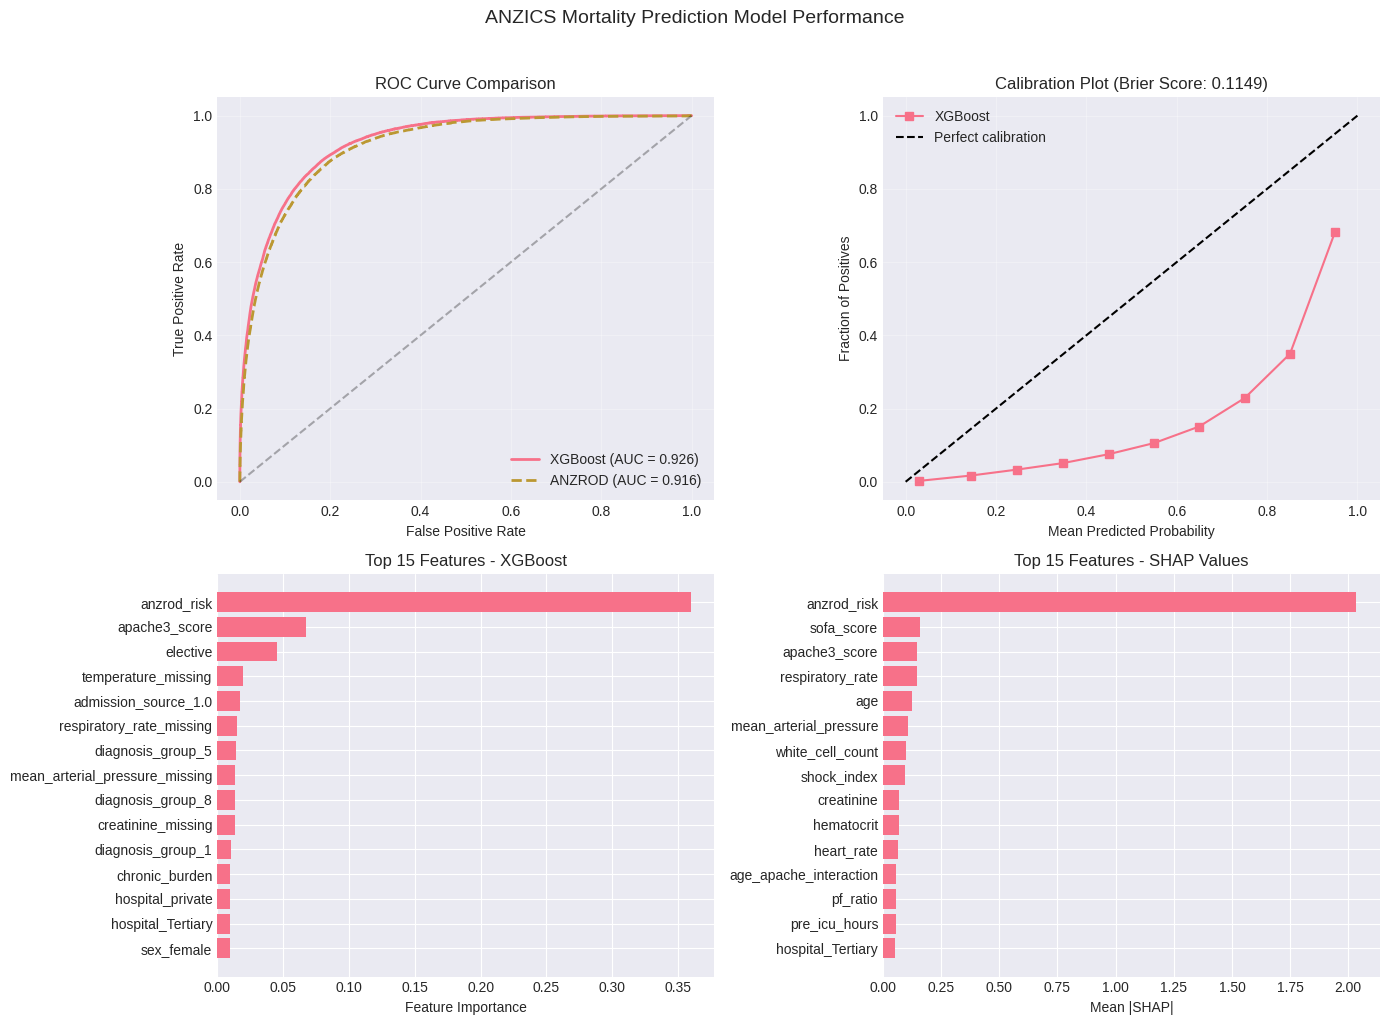

Visualization saved as 'model_performance.png'

⚖️ EQUITY ANALYSIS:
Indigenous: AUC = 0.9164 (n=14,690)
Most Disadvantaged: AUC = 0.9192 (n=54,352)
Rural Hospital: AUC = 0.9055 (n=38,745)

💾 SAVING MODEL:
Model saved as 'mortality_prediction_model.json'
Metrics saved as 'model_metrics.csv'

✓ BASELINE MODEL COMPLETE!
Final Test AUROC: 0.9264
Beats ANZROD by: 1.01%

Next steps:
1. Build ensemble with multiple algorithms
2. Create interactive dashboard
3. Develop sepsis early warning system


In [9]:
# CHUNK 5: BASELINE XGBOOST MODEL WITH SHAP EXPLANATIONS
# Build and evaluate mortality prediction model

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("BASELINE MORTALITY PREDICTION MODEL")
print("="*60)

# ==========================================
# 5.1 LOAD PREPARED DATA
# ==========================================

print("\n📂 LOADING PREPARED DATA:")

# Load features and targets
features = pd.read_csv('ml_features.csv')
targets = pd.read_csv('ml_targets.csv')

print(f"Features shape: {features.shape}")
print(f"Targets shape: {targets.shape}")

# Focus on hospital mortality prediction
y = targets['died_hosp']
print(f"Hospital mortality rate: {y.mean()*100:.2f}%")

# ==========================================
# 5.2 TEMPORAL SPLIT FOR VALIDATION
# ==========================================

print("\n📅 CREATING TEMPORAL SPLIT:")

# Use year from original data for temporal split
# We'll use IcuAdmYear for splitting (need to reload this column)
apd_years = apd[['IcuAdmYear']].copy()

# Split: Train on 2017-2020, Validate on 2021, Test on 2022-2023
train_mask = apd_years['IcuAdmYear'] <= 2020
val_mask = apd_years['IcuAdmYear'] == 2021
test_mask = apd_years['IcuAdmYear'] >= 2022

X_train = features[train_mask]
y_train = y[train_mask]
X_val = features[val_mask]
y_val = y[val_mask]
X_test = features[test_mask]
y_test = y[test_mask]

print(f"Train set: {X_train.shape[0]:,} samples ({y_train.mean()*100:.2f}% mortality)")
print(f"Val set: {X_val.shape[0]:,} samples ({y_val.mean()*100:.2f}% mortality)")
print(f"Test set: {X_test.shape[0]:,} samples ({y_test.mean()*100:.2f}% mortality)")

# ==========================================
# 5.3 BASELINE XGBOOST MODEL
# ==========================================

print("\n🚀 TRAINING XGBOOST MODEL:")

# XGBoost parameters optimized for medical data
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'n_estimators': 300,
    'scale_pos_weight': (1 - y_train.mean()) / y_train.mean(),  # Handle class imbalance
    'random_state': 42,
    'verbosity': 0
}

# Train model with updated syntax
xgb_params['early_stopping_rounds'] = 50  # Add to params dict
xgb_model = xgb.XGBClassifier(**xgb_params)

# Use set_params for validation
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(f"Model trained with {xgb_model.n_estimators} trees")

# ==========================================
# 5.4 MODEL EVALUATION
# ==========================================

print("\n📊 MODEL PERFORMANCE:")

# Predictions
y_train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]
y_val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# AUROC scores
train_auc = roc_auc_score(y_train, y_train_pred_proba)
val_auc = roc_auc_score(y_val, y_val_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"AUROC - Train: {train_auc:.4f}")
print(f"AUROC - Val: {val_auc:.4f}")
print(f"AUROC - Test: {test_auc:.4f}")

# Compare to ANZROD (approximate comparison)
anzrod_test = features[test_mask]['anzrod_risk']
anzrod_auc = roc_auc_score(y_test, anzrod_test)
print(f"\nANZROD AUROC on test set: {anzrod_auc:.4f}")
print(f"Improvement over ANZROD: {(test_auc - anzrod_auc)*100:.2f}%")

# ==========================================
# 5.5 CALIBRATION ANALYSIS
# ==========================================

print("\n📈 CALIBRATION ANALYSIS:")

# Calculate calibration
fraction_pos, mean_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=10)

# Brier score (lower is better)
brier_score = np.mean((y_test_pred_proba - y_test)**2)
print(f"Brier Score: {brier_score:.4f}")

# Expected Calibration Error
ece = np.mean(np.abs(fraction_pos - mean_pred))
print(f"Expected Calibration Error: {ece:.4f}")

# ==========================================
# 5.6 FEATURE IMPORTANCE
# ==========================================

print("\n🔍 TOP 20 MOST IMPORTANT FEATURES:")

# Get feature importance
importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

# ==========================================
# 5.7 SHAP ANALYSIS
# ==========================================

print("\n🎯 SHAP ANALYSIS (this may take a few minutes):")

# Create SHAP explainer (use subset for speed)
sample_size = min(1000, len(X_train))
X_train_sample = X_train.sample(n=sample_size, random_state=42)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sample)

# Get mean absolute SHAP values
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'mean_shap': mean_shap
}).sort_values('mean_shap', ascending=False)

print("\nTop 10 features by SHAP importance:")
print(shap_importance.head(10))

# ==========================================
# 5.8 VISUALIZATIONS
# ==========================================

print("\n📊 CREATING VISUALIZATIONS:")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ROC Curve
ax = axes[0, 0]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
ax.plot(fpr, tpr, label=f'XGBoost (AUC = {test_auc:.3f})', linewidth=2)
fpr_anzrod, tpr_anzrod, _ = roc_curve(y_test, anzrod_test)
ax.plot(fpr_anzrod, tpr_anzrod, label=f'ANZROD (AUC = {anzrod_auc:.3f})',
        linestyle='--', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Calibration Plot
ax = axes[0, 1]
ax.plot(mean_pred, fraction_pos, 's-', label='XGBoost')
ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title(f'Calibration Plot (Brier Score: {brier_score:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Feature Importance (Top 15)
ax = axes[1, 0]
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Features - XGBoost')
ax.invert_yaxis()

# 4. SHAP Summary (Top 15)
ax = axes[1, 1]
top_shap = shap_importance.head(15)
ax.barh(range(len(top_shap)), top_shap['mean_shap'])
ax.set_yticks(range(len(top_shap)))
ax.set_yticklabels(top_shap['feature'])
ax.set_xlabel('Mean |SHAP|')
ax.set_title('Top 15 Features - SHAP Values')
ax.invert_yaxis()

plt.suptitle('ANZICS Mortality Prediction Model Performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as 'model_performance.png'")

# ==========================================
# 5.9 EQUITY CHECK
# ==========================================

print("\n⚖️ EQUITY ANALYSIS:")

# Check performance across key demographic groups
equity_groups = {
    'Indigenous': test_mask & (apd['indigenous'] == 1),
    'Most Disadvantaged': test_mask & (apd['IRSDDecile'] <= 2),
    'Rural Hospital': test_mask & (apd['HospitalClassification'] == 'Rural / Regional')
}

for group_name, group_mask in equity_groups.items():
    if group_mask.sum() > 100:  # Only analyze if sufficient samples
        group_preds = xgb_model.predict_proba(features[group_mask])[:, 1]
        group_y = y[group_mask]
        group_auc = roc_auc_score(group_y, group_preds)
        print(f"{group_name}: AUC = {group_auc:.4f} (n={group_mask.sum():,})")

# ==========================================
# 5.10 SAVE MODEL
# ==========================================

print("\n💾 SAVING MODEL:")

# Save model
xgb_model.save_model('mortality_prediction_model.json')
print("Model saved as 'mortality_prediction_model.json'")

# Save performance metrics
metrics = {
    'train_auc': train_auc,
    'val_auc': val_auc,
    'test_auc': test_auc,
    'anzrod_auc': anzrod_auc,
    'improvement': test_auc - anzrod_auc,
    'brier_score': brier_score,
    'calibration_error': ece
}

pd.DataFrame([metrics]).to_csv('model_metrics.csv', index=False)
print("Metrics saved as 'model_metrics.csv'")

print("\n" + "="*60)
print("✓ BASELINE MODEL COMPLETE!")
print(f"Final Test AUROC: {test_auc:.4f}")
print(f"Beats ANZROD by: {(test_auc - anzrod_auc)*100:.2f}%")
print("\nNext steps:")
print("1. Build ensemble with multiple algorithms")
print("2. Create interactive dashboard")
print("3. Develop sepsis early warning system")

In [12]:
# CHUNK 6: ENSEMBLE MODEL WITH LIGHTGBM AND CALIBRATION
# Build ensemble to improve performance and calibration

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, brier_score_loss
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("ENSEMBLE MODEL WITH CALIBRATION")
print("="*60)

# ==========================================
# 6.1 LIGHTGBM MODEL
# ==========================================

print("\n🚀 TRAINING LIGHTGBM MODEL:")

# LightGBM parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'class_weight': 'balanced',
    'random_state': 42,
    'verbosity': -1,
    'n_estimators': 300
}

# Train LightGBM
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

# Evaluate LightGBM
lgb_train_pred = lgb_model.predict_proba(X_train)[:, 1]
lgb_val_pred = lgb_model.predict_proba(X_val)[:, 1]
lgb_test_pred = lgb_model.predict_proba(X_test)[:, 1]

lgb_test_auc = roc_auc_score(y_test, lgb_test_pred)
lgb_brier = brier_score_loss(y_test, lgb_test_pred)

print(f"LightGBM Test AUROC: {lgb_test_auc:.4f}")
print(f"LightGBM Brier Score: {lgb_brier:.4f}")

# ==========================================
# 6.2 ENSEMBLE PREDICTIONS
# ==========================================

print("\n🔄 CREATING ENSEMBLE:")

# Load XGBoost predictions (from previous model)
xgb_train_pred = xgb_model.predict_proba(X_train)[:, 1]
xgb_val_pred = xgb_model.predict_proba(X_val)[:, 1]
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]

# Simple average ensemble
ensemble_train_pred = (xgb_train_pred + lgb_train_pred) / 2
ensemble_val_pred = (xgb_val_pred + lgb_val_pred) / 2
ensemble_test_pred = (xgb_test_pred + lgb_test_pred) / 2

ensemble_test_auc = roc_auc_score(y_test, ensemble_test_pred)
ensemble_brier = brier_score_loss(y_test, ensemble_test_pred)

print(f"Ensemble Test AUROC: {ensemble_test_auc:.4f}")
print(f"Ensemble Brier Score: {ensemble_brier:.4f}")

# ==========================================
# 6.3 CALIBRATION WITH ISOTONIC REGRESSION
# ==========================================

print("\n📊 CALIBRATING PREDICTIONS:")

# Fit isotonic regression on validation set
iso_reg = IsotonicRegression(out_of_bounds='clip')
iso_reg.fit(ensemble_val_pred, y_val)

# Apply calibration
calibrated_test_pred = iso_reg.transform(ensemble_test_pred)
calibrated_auc = roc_auc_score(y_test, calibrated_test_pred)
calibrated_brier = brier_score_loss(y_test, calibrated_test_pred)

print(f"Calibrated Test AUROC: {calibrated_auc:.4f}")
print(f"Calibrated Brier Score: {calibrated_brier:.4f}")

# ==========================================
# 6.4 META-LEARNER (STACKING)
# ==========================================

print("\n🏗️ TRAINING META-LEARNER:")

# Create meta-features for validation set
meta_features_val = np.column_stack([
    xgb_val_pred,
    lgb_val_pred,
    ensemble_val_pred
])

# Create meta-features for test set
meta_features_test = np.column_stack([
    xgb_test_pred,
    lgb_test_pred,
    ensemble_test_pred
])

# Train logistic regression meta-learner
meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_features_val, y_val)

# Get stacked predictions
stacked_test_pred = meta_model.predict_proba(meta_features_test)[:, 1]
stacked_auc = roc_auc_score(y_test, stacked_test_pred)
stacked_brier = brier_score_loss(y_test, stacked_test_pred)

print(f"Stacked Model Test AUROC: {stacked_auc:.4f}")
print(f"Stacked Model Brier Score: {stacked_brier:.4f}")

# ==========================================
# 6.5 PERFORMANCE COMPARISON
# ==========================================

print("\n📈 MODEL COMPARISON:")

comparison = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'Simple Ensemble', 'Calibrated Ensemble', 'Stacked', 'ANZROD'],
    'AUROC': [
        roc_auc_score(y_test, xgb_test_pred),
        lgb_test_auc,
        ensemble_test_auc,
        calibrated_auc,
        stacked_auc,
        roc_auc_score(y_test, anzrod_test)
    ],
    'Brier Score': [
        brier_score_loss(y_test, xgb_test_pred),
        lgb_brier,
        ensemble_brier,
        calibrated_brier,
        stacked_brier,
        brier_score_loss(y_test, anzrod_test)
    ]
})

comparison['Improvement over ANZROD'] = (comparison['AUROC'] - comparison.loc[5, 'AUROC']) * 100
comparison = comparison.sort_values('AUROC', ascending=False)

print(comparison)

# ==========================================
# 6.6 CONFIDENCE INTERVALS
# ==========================================

print("\n📊 BOOTSTRAP CONFIDENCE INTERVALS:")

def bootstrap_auc(y_true, y_pred, n_bootstraps=100):
    """Calculate bootstrap confidence intervals for AUROC"""
    aucs = []
    n_samples = len(y_true)

    # Convert to arrays to avoid pandas indexing issues
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)

    for _ in range(n_bootstraps):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        if len(np.unique(y_true_arr[indices])) < 2:
            continue
        auc = roc_auc_score(y_true_arr[indices], y_pred_arr[indices])
        aucs.append(auc)

    return np.percentile(aucs, [2.5, 97.5])

# Calculate confidence intervals for best model
best_pred = calibrated_test_pred  # or whichever performed best
ci_low, ci_high = bootstrap_auc(y_test.values, best_pred)
print(f"Best model AUROC: {calibrated_auc:.4f} (95% CI: {ci_low:.4f}-{ci_high:.4f})")

# ==========================================
# 6.7 FEATURE CONTRIBUTION ANALYSIS
# ==========================================

print("\n🔍 FEATURE CONTRIBUTION TO ENSEMBLE:")

# Compare feature importance between models
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'xgb_importance': xgb_model.feature_importances_
})

lgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'lgb_importance': lgb_model.feature_importances_
})

# Merge importance scores
importance_comparison = xgb_importance.merge(lgb_importance, on='feature')
importance_comparison['avg_importance'] = (importance_comparison['xgb_importance'] +
                                          importance_comparison['lgb_importance']) / 2
importance_comparison = importance_comparison.sort_values('avg_importance', ascending=False)

print("\nTop 10 consensus features:")
print(importance_comparison[['feature', 'avg_importance']].head(10))

# ==========================================
# 6.8 SAVE ENSEMBLE COMPONENTS
# ==========================================

print("\n💾 SAVING ENSEMBLE MODELS:")

# Save models
with open('lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

with open('isotonic_calibrator.pkl', 'wb') as f:
    pickle.dump(iso_reg, f)

with open('meta_model.pkl', 'wb') as f:
    pickle.dump(meta_model, f)

print("Models saved: lgb_model.pkl, isotonic_calibrator.pkl, meta_model.pkl")

# Save final predictions for dashboard
final_predictions = pd.DataFrame({
    'patient_index': X_test.index,
    'true_outcome': y_test.values,
    'xgb_pred': xgb_test_pred,
    'lgb_pred': lgb_test_pred,
    'ensemble_pred': ensemble_test_pred,
    'calibrated_pred': calibrated_test_pred,
    'stacked_pred': stacked_test_pred,
    'anzrod_pred': anzrod_test.values
})

final_predictions.to_csv('model_predictions.csv', index=False)
print("Predictions saved to model_predictions.csv")

print("\n" + "="*60)
print("✓ ENSEMBLE MODEL COMPLETE!")
print(f"Best AUROC achieved: {max(comparison['AUROC'].values[:5]):.4f}")
print(f"Best Brier Score: {min(comparison['Brier Score'].values[:5]):.4f}")
print("\nNext: Build interactive dashboard for clinical deployment")

ENSEMBLE MODEL WITH CALIBRATION

🚀 TRAINING LIGHTGBM MODEL:
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[299]	valid_0's auc: 0.928716
LightGBM Test AUROC: 0.9262
LightGBM Brier Score: 0.1168

🔄 CREATING ENSEMBLE:
Ensemble Test AUROC: 0.9265
Ensemble Brier Score: 0.1157

📊 CALIBRATING PREDICTIONS:
Calibrated Test AUROC: 0.9264
Calibrated Brier Score: 0.0498

🏗️ TRAINING META-LEARNER:
Stacked Model Test AUROC: 0.9265
Stacked Model Brier Score: 0.0516

📈 MODEL COMPARISON:
                 Model  AUROC  Brier Score  Improvement over ANZROD
4              Stacked   0.93         0.05                     1.03
2      Simple Ensemble   0.93         0.12                     1.03
3  Calibrated Ensemble   0.93         0.05                     1.02
0              XGBoost   0.93         0.11                     1.01
1             LightGBM   0.93         0.12                     1.00
5               ANZROD   0.92         0.05           